In [3]:
# code for reading a .dat file
import numpy as np
from netCDF4 import Dataset
import netCDF4 as nc4
from myFunctions import lcl
import matplotlib.pyplot as plt
import pandas as pd
import glob
import datetime

%matplotlib inline  
date='20130502'
PathIn = '/Users/cacquist/Lavoro/PBL_hdcp2_s2/PBL_hdcp2_s2_minion/'
dateFiles = ['2013050207', '2013050209', '2013050211', '2013050213', '2013050215', '2013050217', '2013050223']
# names of the variables in the radiosondes profiles
cols = ['time [min:sec]','P [hPa]','T [C]','U [%]','Wind speed [m/s]','Wdir [∞]','Lange [∞]'\
        ,'Breite [∞]','Hˆhe [m]','Geo Pot [m]', 'dew [C]', 'Tv [C]','Rs [m/s]', 'D [kg/m3]', \
        'Azimut []','Elevation []','Entfernung [m]']

processing 2013050207
height where RH = 100%
[]
height of cloud condensation level
948.1
T ccl
289.47137999999995
height of lifting condensation level
nan
----------------------------------------------
processing 2013050209
height where RH = 100%
[]
height of cloud condensation level
938.1
T ccl
289.23337999999995
height of lifting condensation level
nan
----------------------------------------------
processing 2013050211
height where RH = 100%
[]
height of cloud condensation level
968.4
T ccl
289.88032
height of lifting condensation level
nan
----------------------------------------------
processing 2013050213
height where RH = 100%
[]
height of cloud condensation level
1400.8
T ccl
291.78784
height of lifting condensation level
nan
----------------------------------------------
processing 2013050215
height where RH = 100%
[]
height of cloud condensation level
1455.7
T ccl
292.29585999999995
height of lifting condensation level
nan
----------------------------------------------
proces

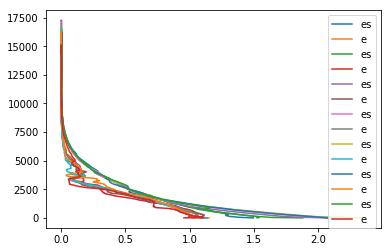

In [6]:
# ---- loop on files from the radiosoundings to extract P, T, Td, RH, CCL, LCL
Radiosondes_data = []
DatetimeArr = ['2013-05-02 07:00:00', '2013-05-02 09:00:00', '2013-05-02 11:00:00',  \
               '2013-05-02 13:00:00','2013-05-02 15:00:00', '2013-05-02 17:00:00', '2013-05-02 23:00:00']
nFiles=len(DatetimeArr)
# loop on all available radiosondes for the day
for ifile in range(nFiles):
    
    dateSel = dateFiles[ifile]
    DF = pd.read_csv(PathIn+'KIT_HOPE_'+dateSel+'.txt', delim_whitespace=True,  names=cols, header=None)
    
    # ---- reading variables in the file
    time = DF.values[:,0]
    P = DF.values[:,1]
    T = DF.values[:,2]
    U = DF.values[:,3]
    Hwind = DF.values[:,4]
    Wdir = DF.values[:,5]
    Td = DF.values[:,10]
    Td = Td + 273.15
    T = T + 273.15
    height = DF.values[:,8]
    Ndata = len(DF.count(axis='columns'))
    print('processing '+dateSel)
    
    # ---- Calculating RH for radiosondes from Td (Td = 1/To - Rv/L log(e/eo)^-1) from stull
    # RH = e/es ; es is from clausius clapeyron while e is obtained from the formula for td 
    e0 = 0.611 # Hpa
    T0 = 273.15 # K
    cost_lrv = 5423. # K (Lv/Rv)

    e = []
    es = []
    RH = []
    for indData in range(Ndata):
        e.append(e0 * np.exp(cost_lrv*(T0**(-1)-Td[indData]**(-1))))
        es.append(e0 * np.exp(cost_lrv*(T0**(-1)-T[indData]**(-1))))
        RH.append(100*(e0 * np.exp(cost_lrv*(T0**(-1)-Td[indData]**(-1))))/(e0 * np.exp(cost_lrv*(T0**(-1)-T[indData]**(-1)))))

    #plt.plot(e, T, label='e')
    plt.plot(es, height, label='es')
    plt.plot(e, height, label='e')
    plt.legend()

    # ---- finding height where RH = 100%
    ind_sat = []
    for indData in range(1,Ndata,+1):
        if ((RH[indData-1] < 100.) and (RH[indData] > 100.)):
            ind_sat = indData
            break
            
    z_sat = height[ind_sat]
    print('height where RH = 100%')
    print(z_sat)
    
    # ---- calculating CCL from radiosoundings
    # ---- calculating the saturation mixing ratio for td at the surface (assuming RH =100%)
    # defining constants
    cost_rvl = np.power(5423,-1.) #K
    Rv = 461 # J K^-1 Kg^-1
    epsilon = 0.622 
    Td_surf = Td[0]
    P_surf = P[0]
    T_surf = T[0]
    M0 = epsilon*e0*np.exp((1./Rv)*(T0**(-1.)-Td_surf**(-1.))) / \
    (P_surf - e0*np.exp((1./Rv)*(T0**(-1.)-Td_surf**(-1.))))

    # ---- calculating mixing ratio profile for each P,T, RH using profile RH
    m =[]
    arg_exp = np.array((1./Rv)*(T0**(-1.)-T**(-1.)))
    for indData in range(Ndata):
        m.append((RH[indData]/100.)*epsilon*e0*np.exp(arg_exp[indData]) / (P[indData] - (RH[indData]/100.)*e0*np.exp(arg_exp[indData])))


    for indData in range(1,Ndata):
        if ((m[indData-1] < M0) and (m[indData] > M0)):
            ind_CCL = indData
            break


    z_ccl = height[ind_CCL]
    print('height of cloud condensation level')
    print(z_ccl)
    
    Ad_rate = -9.8 # K/Km
    T_ground_CCL = []
    # ---- finding z(CCL) using the dry adiabatic lapse rate
    T_top = T[ind_CCL]
    T_ground_CCL = T_top - Ad_rate* z_ccl*10.**(-3)

    print('T ccl')
    print(T_ground_CCL)
    
    
    # ---- calculating LCL height
    #------ calculating LCL heights from tower measurements resampled
    #---------------------------------------------------------------------------------
    from myFunctions import lcl
    z_lcl = lcl(np.array(P_surf),np.array(T_surf),np.array(RH[0])/100.)
    
    print('height of lifting condensation level')
    print(z_lcl)
    print('----------------------------------------------')
    
    
    # ---- saving variables in dictionary
    dict_day = {
        'time':DatetimeArr[ifile],
        'P':P,
        'T':T,
        'Td': Td,
        'Td_surf': Td[0],
        'RH':RH,
        'z_lcl':z_lcl,
        'z_ccl':z_ccl, 
        'T_ccl':T_ground_CCL
    }
    Radiosondes_data.append(dict_day) 



In [7]:
# ---- building global variables form the list of dictionaries
Parray=np.zeros((len(height), nFiles))
Tarray=np.zeros((len(height), nFiles))
Tdarray=np.zeros((len(height), nFiles))
RHarray=np.zeros((len(height), nFiles))
z_ccl_array=np.zeros(nFiles)
T_ccl_array=np.zeros(nFiles)
z_lcl_array=np.zeros(nFiles)
Td_surf_array = np.zeros(nFiles)


date_array= []
for ind in range(nFiles):
    #P[:,ind] = Radiosondes_data[ind]['P']
    z_ccl_array[ind]=Radiosondes_data[ind]['z_ccl']
    z_lcl_array[ind]=Radiosondes_data[ind]['z_lcl']
    T_ccl_array[ind]=Radiosondes_data[ind]['T_ccl']
    Td_surf_array[ind]=Radiosondes_data[ind]['Td_surf']
    date_array.append(Radiosondes_data[ind]['time'])
print(z_ccl_array)
print(T_ccl_array)
print(date_array)
print(Td_surf_array)

[  948.1   938.1   968.4  1400.8  1455.7  1406.9  1464.3]
[ 289.47138  289.23338  289.88032  291.78784  292.29586  292.47762
  292.15014]
['2013-05-02 07:00:00', '2013-05-02 09:00:00', '2013-05-02 11:00:00', '2013-05-02 13:00:00', '2013-05-02 15:00:00', '2013-05-02 17:00:00', '2013-05-02 23:00:00']
[ 282.15  281.75  281.45  281.95  281.85  280.45  279.45]


In [48]:
# ------- saving mean outputs as ncdf for Joyce
f = nc4.Dataset('/Users/cacquist/Desktop/AllRadiosondesData.nc','w', format='NETCDF4')      # creates a netCDF file for writing 
tempgrp = f.createGroup('Temp_data')                                                    # creates a group: A netCDF group is basically a directory or folder within the netCDF dataset
    
# specify dimensions of the data ( each dimension of multidimensiona array needs to be given a name and a length)
tempgrp.createDimension('dimH', len(height))              # dimension for height
tempgrp.createDimension('scalar', 1)                      # dimension for scalars
tempgrp.createDimension('nFiles', nFiles)                 # dimension for date array

# preallocating netCDF variables for data storage
range_height = tempgrp.createVariable('height', 'f4', 'dimH')
date = tempgrp.createVariable('T_ccl', 'f4', 'nFiles')

#P = tempgrp.createVariable('P', 'f4', ('dimH','nFiles'))
#T = tempgrp.createVariable('T', 'f4', ('dimH','nFiles'))
#Td = tempgrp.createVariable('Td', 'f4', ('dimH','nFiles'))
#RH = tempgrp.createVariable('RH', 'f4', ('dimH','nFiles'))
z_cclTemp = tempgrp.createVariable('z_ccl', 'f4', 'nFiles')
z_lclTemp = tempgrp.createVariable('z_lcl', 'f4', 'nFiles')
T_cclTemp = tempgrp.createVariable('T_ccl', 'f4', 'nFiles')
date = tempgrp.createVariable('T_ccl', 'f4', 'nFiles')

# passing data into the variables
#P[:] = Parray
#T[:] = Tarray
#Td[:] = Tdarray
#RH[:] = RHarray
z_cclTemp[:] = z_ccl_array
T_cclTemp[:] = T_ccl_array
z_lclTemp[:] = z_lcl_array
date[:] = date_array


#Add global attributes
f.description = "moisture variables extracted from radiosondes"
f.history = "Created by Claudia Acquistapace cacquist@meteo.uni-koeln.de - University of Cologne"

#Add local attributes to variable instances


    
# closing ncdf file
f.close()


RuntimeError: NetCDF: String match to name in use